# Validation of Ruffed Grouse recognition method

This notebook provides the python code to reproduce results from Lapp et al 2022 (in review in the Wilderness Society Bulletin). 

Specifically, this notebook uses an automated recognition method for ruffed grouse (described in the manuscript) to detect ruffed grouse drumming events in a set of 5-minute annotated audio files. It then calculates metrics of the method's performance. 

This notebook was tested with python 3.8 and opensoundscape==0.7.0. OpenSoundscape is an open-source bioacoustics toolkit for python. To install OpenSoundscape and learn more visit [opensoundscape.org](https://opensoundscape.org)


### Before beginning, download the data:

The data used in this notebook is available through Dryad at the following link: 

https://doi.org/10.5061/dryad.hdr7sqvmc

> contact sam.lapp (at) pitt.edu if the link is broken or you have trouble accessing the data

After downloading the data from Dryad, follow these steps:

- uncompress or unzip the downloaded folder, which may be called `doi_10.5061_dryad.hdr7sqvmc__v2`. This contains a README file and a second, zipped folder with the dataset.

- within this folder, uncompres or unzip the  `ruffed_grouse_validation_set.zip`

- move the entire folder `ruffed_grouse_validation_set` ito the _same folder as this notebook_. To run the cells below, the folder `ruffed_grouse_validation_set` (which contains subfolders `audio` and `annotations`) must be in the same folder as this notebook (which is called `demo_and_validation.ipynb`). 


Related Manuscript: 
> Lapp, S., Larkin, J., Parker, H., Larkin, J., Shaffer, D., Tett, C., McNeil, D., Fiss, C., Kitzes, J., In Review. "Automated recognition of Ruffed Grouse drumming in field recordings". Wildlife Society Bulletin.

### import required packages

In [1]:
from opensoundscape.audio import Audio
from opensoundscape.spectrogram import Spectrogram
from opensoundscape.signal import detect_peak_sequence_cwt

import numpy as np
import pandas as pd
from glob import glob
from pathlib import Path

from tqdm import tqdm 

from matplotlib import pyplot as plt

In [2]:
plt.rcParams['figure.figsize']=[15,5] #for big visuals
%config InlineBackend.figure_format = 'retina'

### parameters
These parameter choices match those used in the WSB 2022 manuscript (Lapp et al. 2022) and are designed to detect ruffed grouse drumming events 

In [3]:
sr = 400 #resample audio to this sample rate
wavelet = 'morl'
peak_threshold = 0.2 
window_len = 60 #sec to analyze in one chunk
center_frequency = 50 #for cwt
peak_separation = 15/400 #min duration (sec) between peaks

### analysis function
The function `detect_peak_sequence_cwt` takes a path to an audio file and performs the automated drumming recognition on sequential non-overlapping clips (windows) of audio. 

Each audio file is analyzed in 60-second non-overlapping windows. For each 60 second window, the function `detect_peak_sequence_cwt` performs two steps to detect drumming events:
1. Extracts peaks from a continuous wavelet transform (50 Hz center frequency) on the audio data
2. Searches the detected peaks for accelerating sequences that match the pattern of ruffed grouse drumming

For further details on the detection method and parameter choices, see the manuscript. 

In [4]:
def detect_ruffed_grouse(path):
    #load the audio file into and Audio object
    audio = Audio.from_file(path)
    
    # analyze 1 window at a time with the recognition method
    
    # All parameters used here are the default parameters of this function in OpenSoundscape 0.7.0,
    # however we write them exiplicitly in case defaults change in a future OpenSoundscape package version
    return detect_peak_sequence_cwt(
        audio,
        sr=sr,
        window_len=window_len,
        center_frequency=center_frequency,
        wavelet=wavelet,
        peak_threshold=peak_threshold,
        peak_separation=peak_separation,
        dt_range=[0.05, 0.8],
        dy_range=[-0.2, 0],
        d2y_range=[-0.05, 0.15],
        max_skip=3,
        duration_range=[1, 15],
        points_range=[9, 100],
        plot=False,
    ) #returns a dataframe summarizing all detected sequences

## Analyze one file and examine a detection

In [5]:
path = './ruffed_grouse_validation_set/audio/20200425/LSD-0028/20200425_114000_0s-300s.wav'
detect_ruffed_grouse(path)

,sequence_y,sequence_t,window_start_t,seq_len,seq_start_time,seq_end_time,seq_midpoint_time
0,"[0.5425226051085454, 0.46501937580732555, 0.40...","[65.5077294887287, 66.05025209383724, 66.51527...",60.0,24,65.507729,70.335431,67.921580
1,"[0.6050252093837223, 0.4900204175173961, 0.437...","[149.87874494770614, 150.48377015708988, 150.9...",120.0,22,149.878745,155.296471,152.587608
2,"[0.16000666694445598, 0.15750656277344888, 0.1...","[240.29751239634984, 240.68252843868495, 241.0...",240.0,11,240.297512,241.992583,241.145048


> **TIP**: if you recieve an error, make sure you've downloaded the data and moved the entire folder titled `ruffed_grouse_validation_set` into the same folder as this notebook

We can see that the first detection, which contains 24 pulses in a sequence, begins in the window starting at 60 seconds, and starts 5.5 seconds into that window. Let's look at that section of the audio file as a spectrogram (note that we bandpass the spectrogram to 0-1000 Hz to zoom in on the low frequencies):

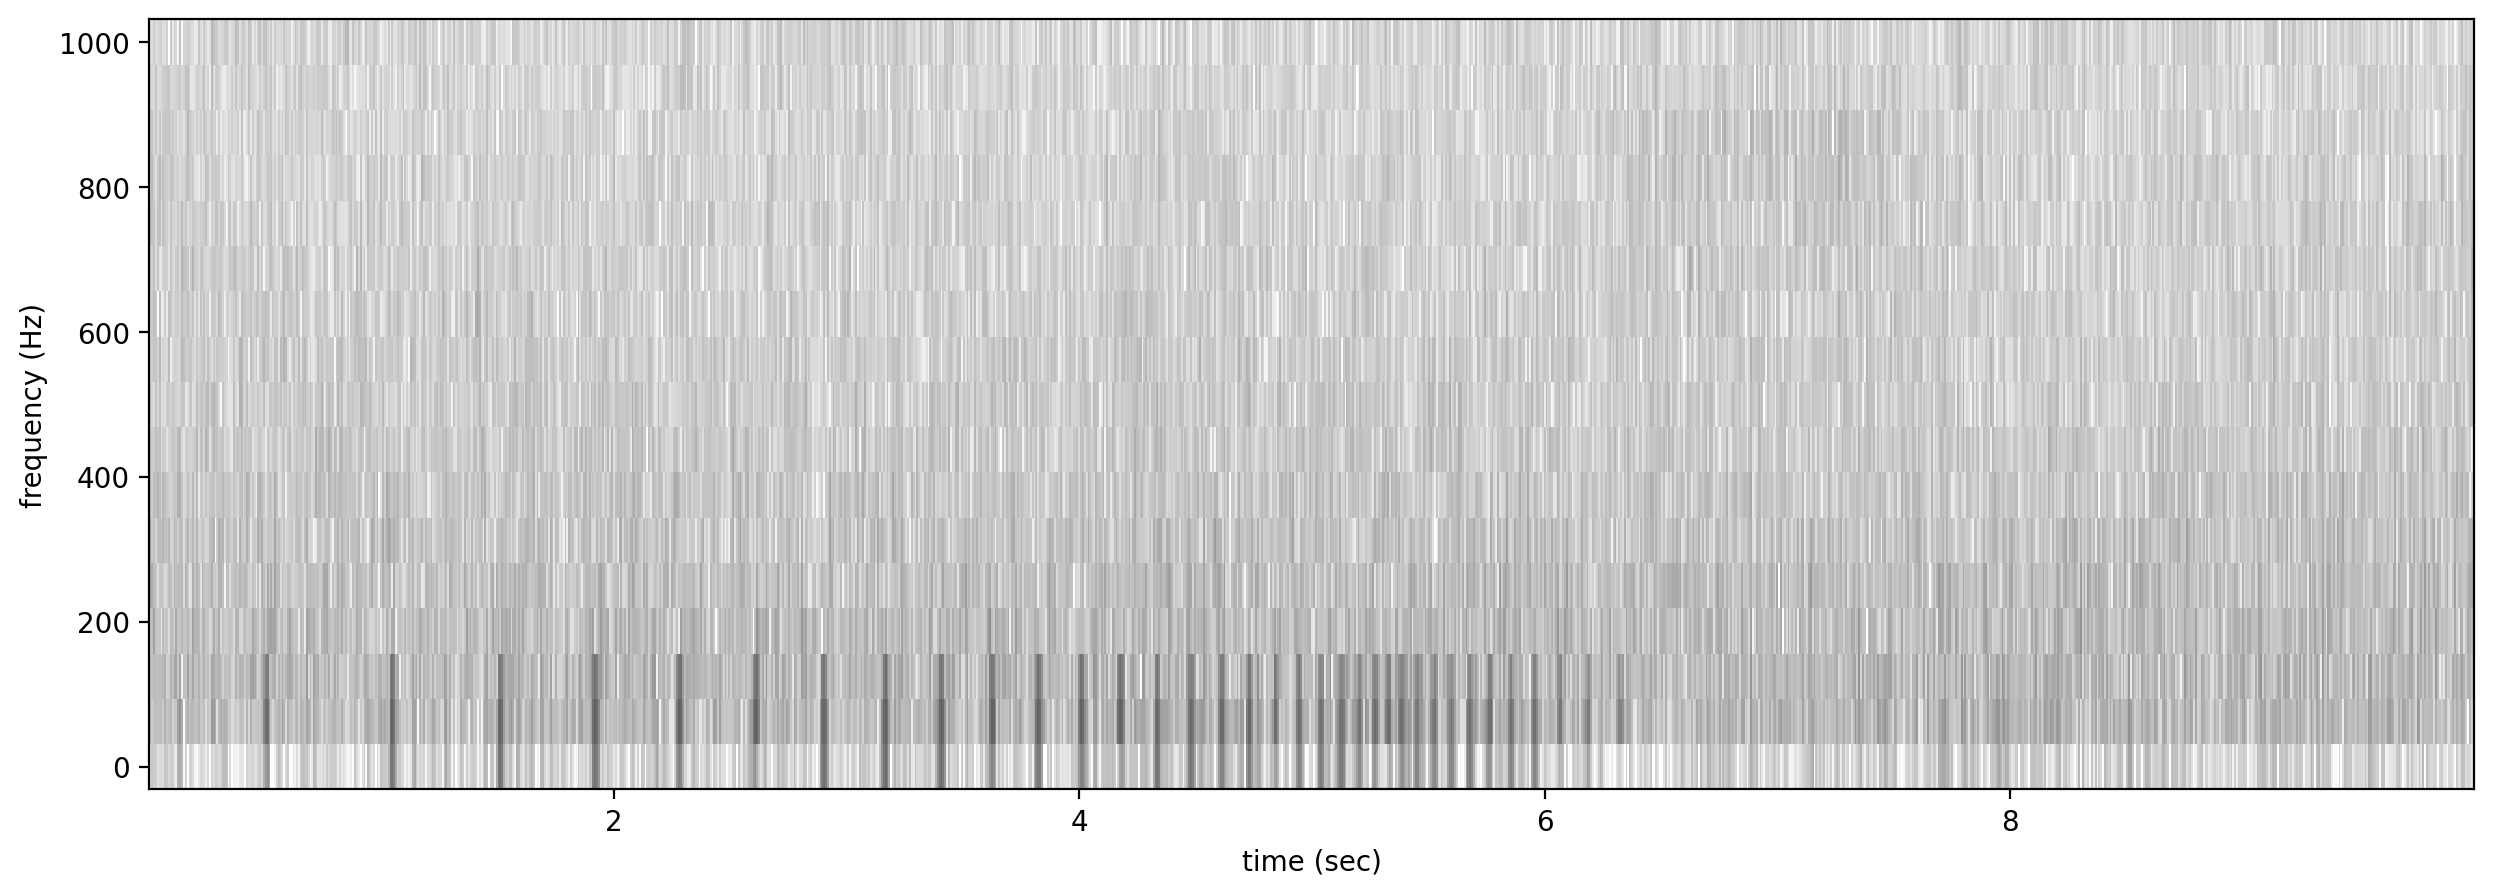

In [7]:
#load the relevant audio
audio_clip_with_detection = Audio.from_file(path,offset=65,duration=10)

#create a spectrogram
spec = Spectrogram.from_audio(audio_clip_with_detection).bandpass(0,1000)

#plot the spectrogram
spec.plot()

#display the audio in a playable IPython object
from IPython import display
display.Audio(audio_clip_with_detection.samples,rate=audio_clip_with_detection.sample_rate)

We can clearly see the ruffed grouse drumming event in the spectrogram. If you have speakers or headphones with good low-frequency response, you can also hear the accellerating thumping of the ruffed grouse drumming display by clicking play on the audio player. 

## Analyze all files in the validation set
The next cell **will take a while** to run because it requires analyzing 1120 minutes of audio. If you wish, you can skip this cell (which analyzes the audio) and instead run the commented out cell below to load the results of the analysis from a .csv file. 

In [8]:
#get a list of all files
files = glob('./ruffed_grouse_validation_set/audio/*/*/*.wav')

In [28]:
print(f"analyzing {len(files)} files")

#run the detector on each file, saving output dataframes in a list
all_results = []
for f in tqdm(files):
    results_df = detect_ruffed_grouse(f)
    if len(results_df)>0:
        results_df.index = [f]*len(results_df)
        results_df.index.name = 'file'
        all_results.append(results_df)
    
if len(all_results)>0:
    all_results_df = pd.concat(all_results)
else:
    print('no detections in this set of files')

analyzing 224 files


100%|██████████| 224/224 [07:56<00:00,  2.13s/it]


In [31]:
# save results if desired
all_results_df.to_csv('saved_recognizer_outputs.csv')

If you choose to skip the 2 cells above, uncomment and run the cell below to load the previously computed outputs from the model

In [9]:
#all_results_df = pd.read_csv('saved_recognizer_outputs.csv').set_index('file')

Take a quick look at the longest detected sequences

In [10]:
all_results_df.sort_values(by='seq_len',ascending=False).head()

,sequence_y,sequence_t,window_start_t,seq_len,seq_start_time,seq_end_time,seq_midpoint_time
file,,,,,,,
./ruffed_grouse_validation_set/audio/20200425/LSD-0014/20200425_114000_0s-300s.wav,"[0.6375265636068157, 0.5175215633984749, 0.460...","[24.738530772115503, 25.37605733572232, 25.893...",0.0,25,24.738531,30.348765,27.543648
./ruffed_grouse_validation_set/audio/20200516/LSD-0014/20200516_114000_0s-300s.wav,"[0.6175257302387598, 0.5250218759114964, 0.440...","[121.91257969082045, 122.5301054210592, 123.05...",120.0,25,121.912580,127.455311,124.683945
./ruffed_grouse_validation_set/audio/20200425/LSD-0028/20200425_114000_0s-300s.wav,"[0.5425226051085454, 0.46501937580732555, 0.40...","[65.5077294887287, 66.05025209383724, 66.51527...",60.0,24,65.507729,70.335431,67.921580
./ruffed_grouse_validation_set/audio/20200507/LSD-0029/20200507_114000_0s-300s.wav,"[0.5475228134505628, 0.4650193758073229, 0.410...","[94.43643485145213, 94.9839576649027, 95.44897...",60.0,24,94.436435,99.284137,96.860286
./ruffed_grouse_validation_set/audio/20200516/LSD-0029/20200516_114000_0s-300s.wav,"[0.5475228134505556, 0.46501937580733, 0.41001...","[165.1643818492437, 165.71190466269428, 166.17...",120.0,24,165.164382,170.032085,167.598233


## load labels for 1-minute clips
This table has a label for each minute of each 5-minute audio clip: 1 if it contains ruffed grouse drumming and 0 otherwise. It was generated from the raven selection tables included in `./validation-set/annotations`. To see the details on how the table was generated, scroll to the bottom of this notebook. 

In [11]:
label_df_1min = pd.read_csv('./1minute_presence_absence_labels.csv').set_index('file')
label_df_1min.head()

,1,2,3,4,5
file,,,,,
./ruffed_grouse_validation_set/audio/20200425/LSD-0021/20200425_114000_0s-300s.wav,0.0,0.0,0.0,0.0,0.0
./ruffed_grouse_validation_set/audio/20200425/LSD-0019/20200425_114000_0s-300s.wav,0.0,0.0,0.0,0.0,0.0
./ruffed_grouse_validation_set/audio/20200425/LSD-0010/20200425_114000_0s-300s.wav,0.0,0.0,0.0,0.0,0.0
./ruffed_grouse_validation_set/audio/20200425/LSD-0028/20200425_114000_0s-300s.wav,0.0,1.0,1.0,1.0,1.0
./ruffed_grouse_validation_set/audio/20200425/LSD-0017/20200425_114000_0s-300s.wav,0.0,0.0,0.0,0.0,0.0


## Evaluate the performance of the recognizer
Now that we have created 1-minute labels on the validation set and have generated detections with the automated recognizer, we can evaluate its performance using precision, recall, and f1 score (see [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html) for definitions).



In [12]:
from sklearn.metrics import precision_recall_fscore_support

Summarize detection/non-detection data (1 or 0) on 1-minute clips for the automated recognizer scores. 

In [13]:
all_results_df['minute']=(all_results_df.window_start_t//60 + 1).astype(int)
all_results_df = all_results_df.reset_index()

#create a table of 0/1 (non-detection/detection) for 5 minute file x minute
detection_1min = [[len(all_results_df[(all_results_df.file==file) &  (all_results_df.minute==m)])>0  
                   for m in [1,2,3,4,5]]
                  for file in label_df_1min.index]
detection_df_1min = pd.DataFrame(detection_1min,index=label_df_1min.index,columns=label_df_1min.columns)

flatten the labels and values to 1-d arrays (the format expected by sklearn.metrics)

In [14]:
labels = [l for row in label_df_1min.values for l in row]
detections = [d for row in detection_df_1min.values for d in row]

#### Calculate performance metrics on the validation set (1 minute clips)

In [15]:
precision,recall,f1,support  = precision_recall_fscore_support(labels,detections)
print(f'precision for ruffed grouse presence: {precision[1]:0.3f}')
print(f'recall for ruffed grouse presence: {recall[1]:0.3f}')
print(f'F1 score for ruffed grouse presence: {f1[1]:0.3f}')

precision for ruffed grouse presence: 0.707
recall for ruffed grouse presence: 0.784
F1 score for ruffed grouse presence: 0.744


This confusion matrix counts:
```
True Negatives, False Negatives
False Positives, True Positives
```

In [21]:
from sklearn.metrics import confusion_matrix
[[true_negatives, false_negatives],[false_positives,true_positives]] = confusion_matrix(labels,detections)
print(f"true negatives: {true_negatives}")
print(f"false negatives: {false_negatives}")
print(f"false positives: {false_positives}")
print(f"true positives: {true_positives}")

true negatives: 1071
false negatives: 12
false positives: 8
true positives: 29


### Also compute metrics on 5-minute clips

Label 5-minute clips by presence or absence of ruffed grouse drumming, and evaluate the precision and recall on these 5-minute clips:

In [22]:
dets_5min = detection_df_1min.max(1).astype(int)
labels_5min = label_df_1min.max(1).astype(int)

precision,recall,f1,support  = precision_recall_fscore_support(labels_5min,dets_5min)
print(f'precision for ruffed grouse presence: {precision[1]:0.3f}')
print(f'recall for ruffed grouse presence: {recall[1]:0.3f}')
print(f'F1 score for ruffed grouse presence: {f1[1]:0.3f}')

precision for ruffed grouse presence: 0.607
recall for ruffed grouse presence: 1.000
F1 score for ruffed grouse presence: 0.756







### Extra details: creating 1-minute labels from Raven annotations
You can use the pre-generated set of 1-minute labels, but if you want to see how they are created from the Raven annotation folders, use the code below

In [23]:
from opensoundscape.annotations import BoxedAnnotations
all_labels = []
for f in files:
    annotation_file = f.replace('audio','annotations').replace('.wav','.Table.1.selections.txt')

    try:
        ann = BoxedAnnotations.from_raven_file(annotation_file, annotation_column='Species')
    except:
        #annotation file doesn't exist, so this file has no labels
        all_labels.append([0]*5)
        continue

    
    if len(ann.df)<1:
        #annotation file contains no annotations
        all_labels.append([0]*5)
        continue
    
    minute_labels = ann.one_hot_clip_labels(
        clip_duration=60, #separate into one label per 60 seconds of audio
        clip_overlap=0,  #with no overlap between clips
        classes=None, #include all classes (we only have Rugr annotations in these files)
        min_label_overlap=0, #any overlapping annotations, regardless of how much overlap, are included
        full_duration=60*5 #length of entire audio file
    )
    

    all_labels.append(list(minute_labels.Rugr.values))


how many 1-minute clips are labeled as having ruffed grouse drumming?

In [24]:
np.sum(all_labels)

37.0

In [25]:
#make sure each 1 minute clip has a label
assert len([f for x in all_labels for i in x ]) == 1120

save labels to a table

In [26]:
label_df_1min = pd.DataFrame(all_labels,index=files,columns=[1,2,3,4,5])
label_df_1min.index.name='file'
label_df_1min.to_csv('./1minute_presence_absence_labels.csv')